In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

sns.set()

from IPython.display import display
from tools import make_track, ols_regression, make_ER, lasso_regression, lasso_regression_ic, ridge_regression,\
    kalman_filter, kalman_with_selection, selective_kalman_filter, replication_stats
from hc_graph import hc_stock, hc_piechart, hc_spiderweb

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


In [3]:
fund_name = 'HFRXM'
pd.read_csv(r"financial_data/hfrx_index_names.csv", index_col=0)

,Full Name
Name,
HFRXAR,HFRX Absolute Return Index
HFRXDS,HFRX ED: Distressed Restructuring Index
HFRXMA,HFRX ED: Merger Arbitrage Index
HFRXSS,HFRX ED: Special Situations Index
HFRXEMN,HFRX EH: Equity Market Neutral Index
HFRXEHG,HFRX EH: Fundamental Growth Index
HFRXEHV,HFRX EH: Fundamental Value Index
HFRXEMC,HFRX Emerging Markets Composite Index
HFRXEWC,HFRX Equal Weighted Strategies CHF Index


### Financial data loads and cleaning

In [4]:
# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()
hfrx = make_ER(hfrx_all[[fund_name]].dropna(), US_rate)

# BNP

bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True) #[["BNPIFEU","BNPIFUS",
                 #"BNPIFJP","BNPIFCN","BNPIFFR","BNPIFGE","BNPIFGB","BNPIFCH","BNPIFKR","BNPIFUSC","BNPIFBR",
                 #"BNPIFAU","BNPIFHK","BNPIFTW","BNPIFSG","BNPIFIT","BNPIFSP","BNPIFSW","BNPIFNE","BNPIFRU","BNPIFEM"]]

risk_premia = pd.read_pickle("financial_data/risk_premia_ER_FX_USD.pkl") #[["BNPICCE3","BNPIVMRU","BNPIAIRT","BNPIAIRU",
                  #"BNPIEC03","BNPIPLEE","BNPIPMEE","BNPIPQEE","BNPIPVEE","BNPILUEE","BNPIPMUH","BNPIPQUH",
                  #"BNPIPVUH","BNPIAIRG","BNPIAIRJ","BNPIAIRE"]]

In [5]:
df_info = pd.read_csv(r"financial_data/bnp_info.csv", index_col=0)
df_info.head()

,Asset Class,Style
Ticker,,
BNPIDRXA,Commodity,Carry
BNPIF3AX,Commodity,Carry
BNPIF3XM,Commodity,Momentum
BPFXSTGU,FX,Value
BNPICCE3,Equity,Carry


In [6]:
prices_all = bnp.join(risk_premia,how="outer").ffill().join(hfrx,how="inner")

In [7]:
returns_all = prices_all.resample('1D').first().pct_change().dropna()
hrfx_returns = returns_all[[fund_name]]
returns_all = returns_all.drop(fund_name, axis=1)
prices_all = prices_all.drop(fund_name, axis=1)

In [8]:
alpha = hrfx_returns[fund_name].autocorr(lag=1)
hrfx_returns_adj = ((hrfx_returns - alpha * hrfx_returns.shift(1)) / (1. - alpha)).fillna(0) # 'liquidity adjustment' for
                                                                                             # removing returns autocorrelation
beta = hrfx_returns_adj[fund_name].autocorr(lag=1)

Auto-correlation of HFRXM returns : 0.0773252367704
Auto-correlation of HFRXM adjusted returns : -0.0023386222146


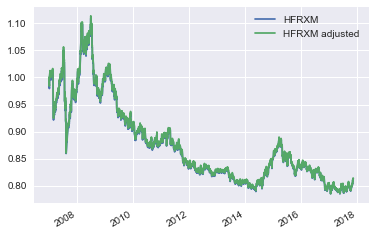

In [9]:
print("Auto-correlation of",fund_name,"returns :", alpha)
print("Auto-correlation of",fund_name,"adjusted returns :", beta)
ax = (1 + hrfx_returns).cumprod().plot()
_ = (1 + hrfx_returns_adj).cumprod()[fund_name].plot(label=fund_name + ' adjusted', legend=True, ax=ax)

In [10]:
size = 126
freq = 5

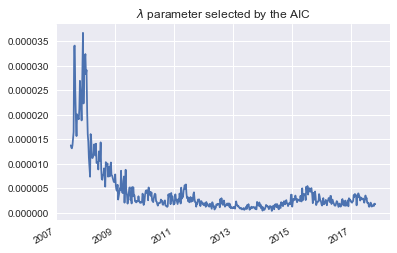

Wall time: 36.3 s


In [11]:
%%time
df_weight_aic, _ = lasso_regression_ic(hrfx_returns, returns_all,sample_length=size, frequency=freq, criterion='aic')
prices_for_track_aic = prices_all.loc[df_weight_aic.index[0]:]

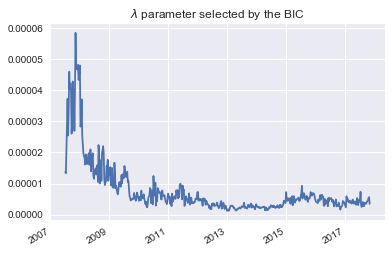

Wall time: 34.5 s


In [12]:
%%time
df_weight_bic, _ = lasso_regression_ic(hrfx_returns, returns_all,sample_length=size, frequency=freq, criterion='bic')
prices_for_track_bic = prices_all.loc[df_weight_bic.index[0]:]

In [13]:
%%time
nu = 1.
df_weight_kalman = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=1. , sigma_return=nu)

prices_for_track_kalman = prices_all.loc[df_weight_kalman.index[0]:]

Wall time: 1.72 s


In [14]:
%%time
df_weight_kalman_bic = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic')

prices_for_track_kalman_bic = prices_all.loc[df_weight_kalman_bic.index[0]:]

Wall time: 35.7 s


In [15]:
%%time
df_weight_kalman_aic = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic')

prices_for_track_kalman_aic = prices_all.loc[df_weight_kalman_aic.index[0]:]

Wall time: 35.7 s


In [16]:
%%time
tc = 0.0005
lag = 1

replication_aic = make_track(prices_for_track_aic, df_weight_aic, tc=tc, lag=lag)
df_res = hfrx.loc[replication_aic.index]
df_res["Lasso AIC"] = replication_aic

replication_bic = make_track(prices_for_track_bic, df_weight_bic, tc=tc, lag=lag)
df_res["Lasso BIC"] = replication_bic

replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman"] = replication_kalman

replication_kalman_aic = make_track(prices_for_track_kalman_aic, df_weight_kalman_aic, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman AIC"] = replication_kalman_aic

replication_kalman_bic = make_track(prices_for_track_kalman_bic, df_weight_kalman_bic, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman BIC"] = replication_kalman_bic

Wall time: 12.9 s


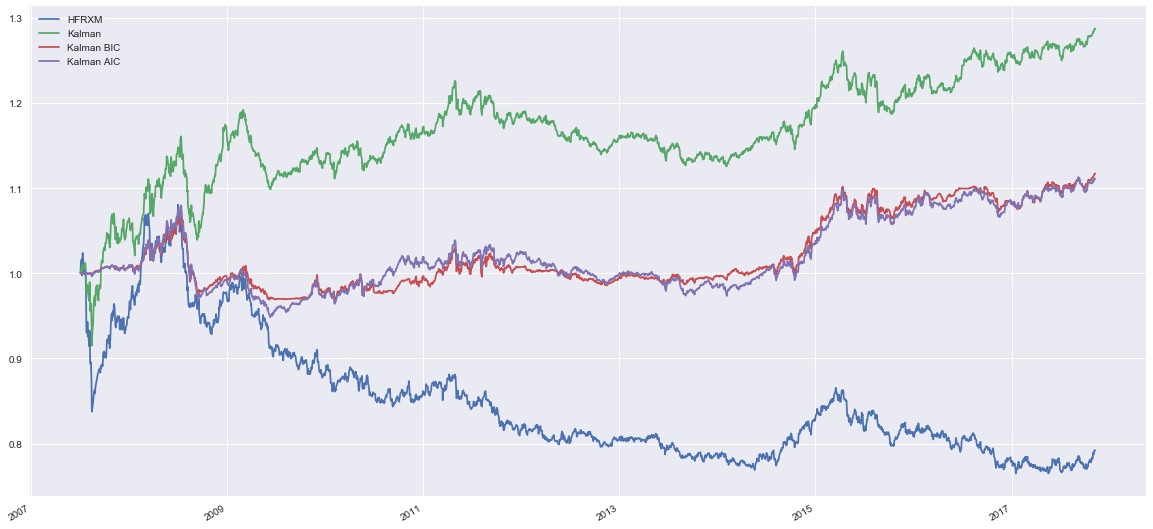

In [17]:
df_res = (df_res / df_res.iloc[0])
df_res[[fund_name, 'Kalman', 'Kalman BIC', 'Kalman AIC']].plot(figsize=(20,10))

In [18]:
df_stat = replication_stats(df_res, fund_name=fund_name)
df_stat

,Tracking error,R-squared,Sharpe ratio,Annual Return,Correlation,Kendall tau
HFRXM,0.000000,1.000000,-0.327874,-0.0222905,1.000000,1.000000
Lasso AIC,0.002970,0.435228,0.206810,0.00756257,0.660087,0.415016
Lasso BIC,0.003094,0.387419,0.311497,0.00947745,0.635346,0.388794
Kalman,0.002974,0.433822,0.512522,0.0246333,0.670588,0.448019
Kalman AIC,0.003337,0.287032,0.309828,0.0101916,0.536259,0.390066
Kalman BIC,0.003420,0.251335,0.355657,0.0107318,0.501621,0.366663


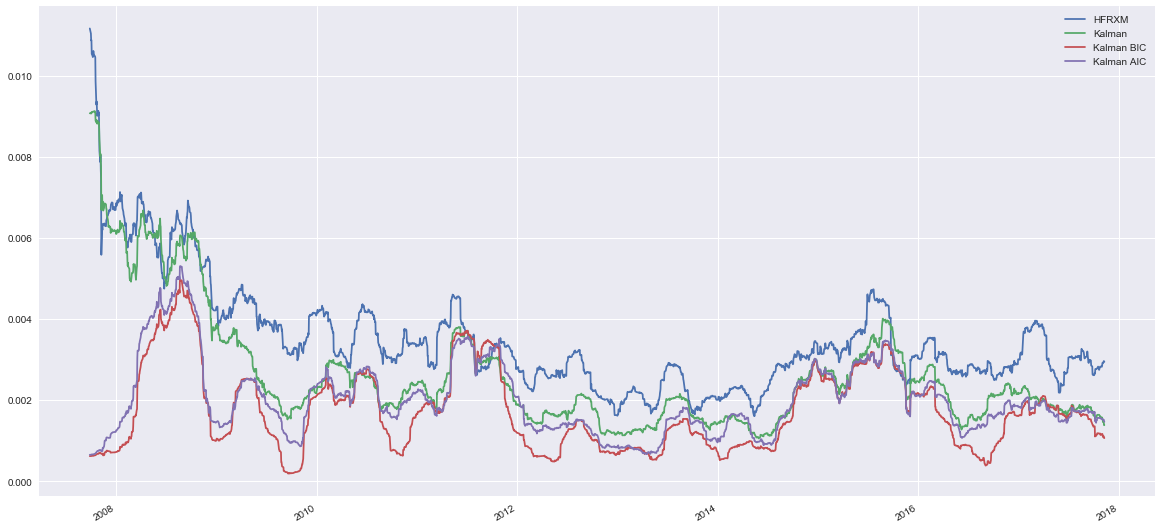

In [19]:
vol = df_res.pct_change().rolling(window=60).std().dropna()
vol[[fund_name, 'Kalman', 'Kalman BIC', 'Kalman AIC']].plot(figsize=(20,10))

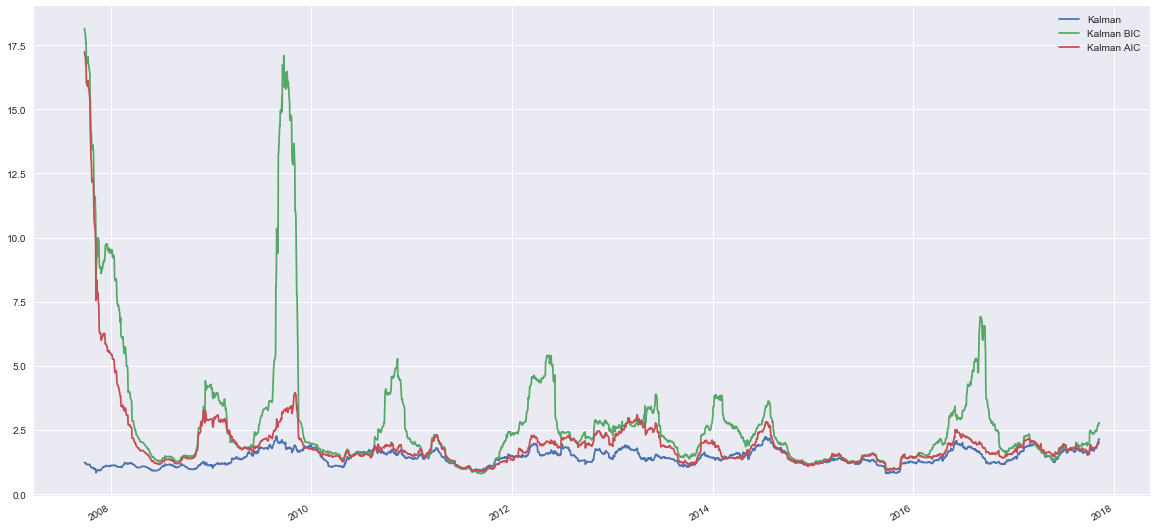

In [20]:
vol_fund = vol[fund_name]
vol_ratio = 1. / vol.div(vol_fund, axis='index').drop(fund_name, axis=1)
vol_ratio[['Kalman', 'Kalman BIC', 'Kalman AIC']].plot(figsize=(20,10))

### Vol adjustment

In [21]:
df_weight_kalman_aic_voladj = df_weight_kalman_aic.multiply(vol_ratio['Kalman AIC'], axis='index').dropna()
df_weight_kalman_bic_voladj = df_weight_kalman_bic.multiply(vol_ratio['Kalman BIC'], axis='index').dropna()
df_weight_kalman_voladj = df_weight_kalman.multiply(vol_ratio['Kalman'], axis='index').dropna()

prices_for_track_all = prices_for_track_aic[df_weight_aic.multiply(vol_ratio['Lasso AIC'], axis='index').dropna().index[0]:]

replication_aic_voladj = make_track(prices_for_track_all, df_weight_aic.multiply(vol_ratio['Lasso AIC'], axis='index').dropna(), tc=tc, lag=lag)
df_res_voladj = hfrx.loc[replication_aic_voladj.index]
df_res_voladj["Lasso AIC"] = replication_aic_voladj

replication_bic_voladj = make_track(prices_for_track_all, df_weight_bic.multiply(vol_ratio['Lasso BIC'], axis='index').dropna(), tc=tc, lag=lag)
df_res_voladj["Lasso BIC"] = replication_bic_voladj

prices_for_track_all = prices_for_track_kalman[df_weight_kalman.multiply(vol_ratio['Kalman'], axis='index').dropna().index[0]:]

replication_kalman_voladj = make_track(prices_for_track_all, df_weight_kalman_voladj, tc=tc, lag=lag).loc[df_res_voladj.index[0]:]
df_res_voladj["Kalman"] = replication_kalman_voladj

prices_for_track_all = prices_for_track_kalman_aic[df_weight_kalman_aic.multiply(vol_ratio['Kalman AIC'], axis='index').dropna().index[0]:]

replication_kalman_aic_voladj = make_track(prices_for_track_all, df_weight_kalman_aic_voladj, tc=tc, lag=lag).loc[df_res_voladj.index[0]:]
df_res_voladj["Kalman AIC"] = replication_kalman_aic_voladj

replication_kalman_bic_voladj = make_track(prices_for_track_all,df_weight_kalman_bic_voladj, tc=tc, lag=lag).loc[df_res_voladj.index[0]:]
df_res_voladj["Kalman BIC"] = replication_kalman_bic_voladj

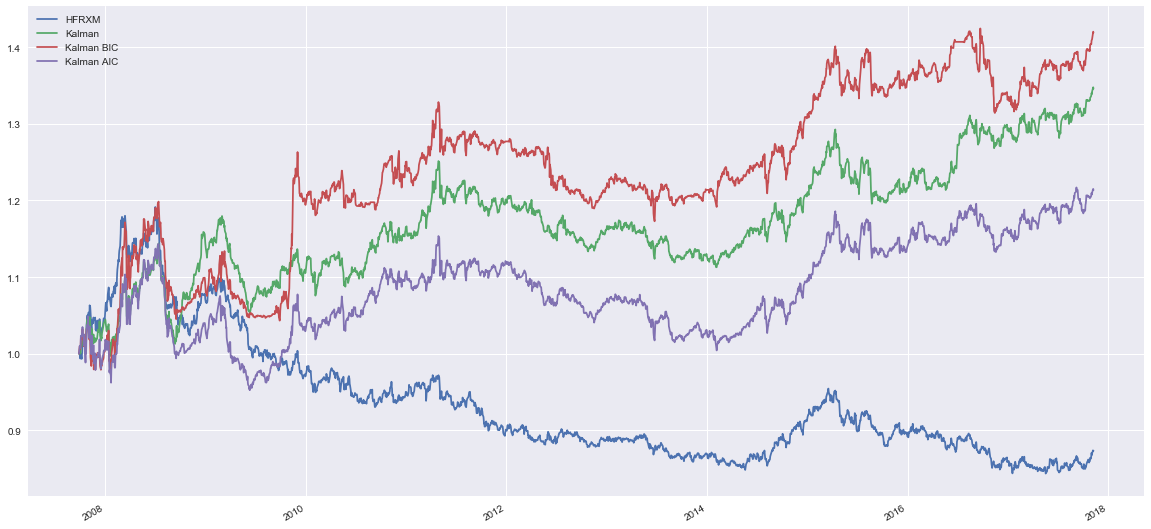

In [22]:
df_res_voladj = df_res_voladj.bfill()
df_res_voladj = (df_res_voladj / df_res_voladj.iloc[0])
df_res_voladj[[fund_name, 'Kalman', 'Kalman BIC', 'Kalman AIC']].plot(figsize=(20,10))

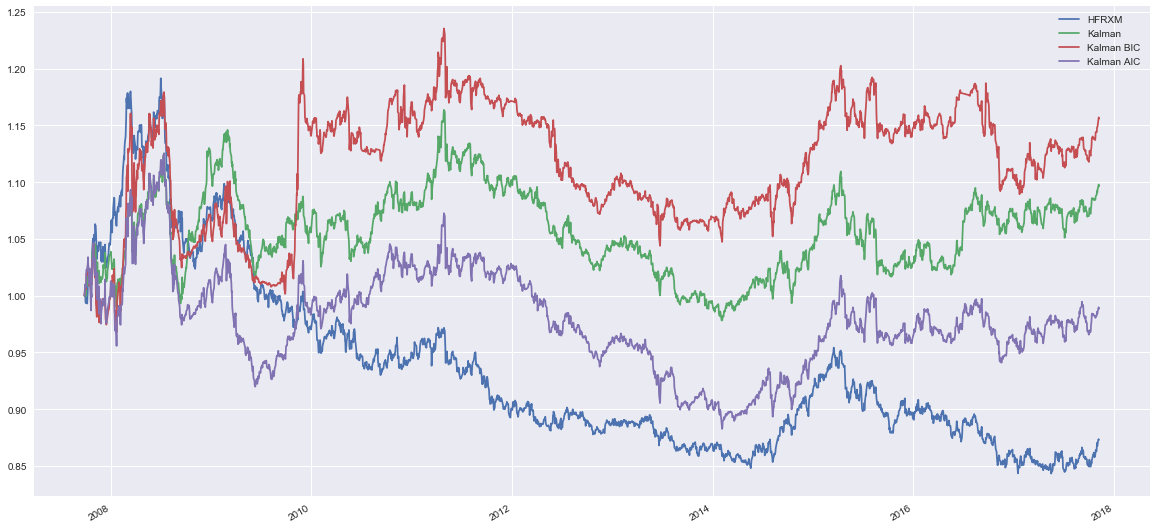

In [23]:
df_res_volperfadj = df_res_voladj[[fund_name]].copy()
temp = df_res_voladj.drop(fund_name, axis=1)
df_res_volperfadj[temp.columns]= make_ER(temp, 2 + 0 * US_rate)
df_res_volperfadj[[fund_name, 'Kalman', 'Kalman BIC', 'Kalman AIC']].plot(figsize=(20,10))

## Statistics on replication

In [24]:
df_stat_vol = replication_stats(df_res_voladj, fund_name=fund_name)
df_stat_vol

,Tracking error,R-squared,Sharpe ratio,Annual Return,Correlation,Kendall tau
HFRXM,0.000000,1.000000,-0.205283,-0.013326,1.000000,1.000000
Lasso AIC,0.003255,0.188345,0.102708,0.004380,0.615170,0.404820
Lasso BIC,0.003484,0.069948,0.143214,0.007084,0.583925,0.376760
Kalman,0.003072,0.277030,0.531991,0.029807,0.645565,0.438360
Kalman AIC,0.003488,0.067548,0.317865,0.019312,0.615907,0.401899
Kalman BIC,0.003870,-0.147313,0.511094,0.035210,0.578001,0.381845


## Volatility contributions

In [25]:
df_vol_contrib_kalman_voladj = (prices_all.reindex(df_weight_kalman_voladj.index).pct_change()*df_weight_kalman_voladj).std()
df_vol_contrib_kalman_voladj = df_vol_contrib_kalman_voladj/df_vol_contrib_kalman_voladj.sum()

df_vol_contrib_kalman_bic_voladj = (prices_all.reindex(df_weight_kalman_bic_voladj.index).pct_change()*df_weight_kalman_bic_voladj).std()
df_vol_contrib_kalman_bic_voladj = df_vol_contrib_kalman_bic_voladj/df_vol_contrib_kalman_bic_voladj.sum()

df_vol_contrib_kalman_aic_voladj = (prices_all.reindex(df_weight_kalman_aic_voladj.index).pct_change()*df_weight_kalman_aic_voladj).std()
df_vol_contrib_kalman_aic_voladj = df_vol_contrib_kalman_aic_voladj/df_vol_contrib_kalman_aic_voladj.sum()

In [26]:
df_vol_contrib = pd.DataFrame()
df_vol_contrib["Kalman"] = df_vol_contrib_kalman_voladj
df_vol_contrib["Kalman BIC"] = df_vol_contrib_kalman_bic_voladj
df_vol_contrib["Kalman AIC"] = df_vol_contrib_kalman_aic_voladj
df_vol_contrib = df_vol_contrib.join(df_info).reset_index()

In [27]:
df_vol_contrib_asset_class = df_vol_contrib.drop(["Style"],axis=1).groupby(["Asset Class","index"]).sum()
df_vol_contrib_style = df_vol_contrib.drop(["Asset Class"],axis=1).groupby(["Style","index"]).sum()

In [28]:
g = hc_spiderweb(df_vol_contrib_asset_class, title="Vol contribution by Asset Class")
g.plot()

In [29]:
g = hc_spiderweb(df_vol_contrib_style, title="Vol contribution by Style")
g.plot()

In [30]:
g = hc_piechart(df_vol_contrib_asset_class[["Kalman BIC"]], title="Vol contribution by Asset Class in Kalman BIC")
g.plot()

In [31]:
g = hc_piechart(df_vol_contrib_style[["Kalman BIC"]], title="Vol contribution by Style in Kalman BIC")
g.plot()

## Performance contributions

In [32]:
df_perf_contrib_kalman_voladj = (1 + prices_all.reindex(df_weight_kalman_voladj.index).pct_change()*df_weight_kalman_voladj).prod() - 1

df_perf_contrib_kalman_bic_voladj = (1 + prices_all.reindex(df_weight_kalman_bic_voladj.index).pct_change()*df_weight_kalman_bic_voladj).prod() - 1

df_perf_contrib_kalman_aic_voladj = (1 + prices_all.reindex(df_weight_kalman_aic_voladj.index).pct_change()*df_weight_kalman_aic_voladj).prod() - 1

In [33]:
df_perf_contrib = pd.DataFrame()
df_perf_contrib["Kalman"] = df_perf_contrib_kalman_voladj
df_perf_contrib["Kalman BIC"] = df_perf_contrib_kalman_bic_voladj
df_perf_contrib["Kalman AIC"] = df_perf_contrib_kalman_aic_voladj
df_perf_contrib = df_perf_contrib.join(df_info).reset_index()

In [34]:
df_perf_contrib_asset_class = df_perf_contrib.drop(["Style"],axis=1).groupby(["Asset Class","index"]).sum()
df_perf_contrib_style = df_perf_contrib.drop(["Asset Class"],axis=1).groupby(["Style","index"]).sum()

In [35]:
g = hc_spiderweb(df_perf_contrib_asset_class, title="Vol contribution by Asset Class")
g.plot()

In [36]:
g = hc_spiderweb(df_perf_contrib_style, title="Vol contribution by Style")
g.plot()

## Average exposures

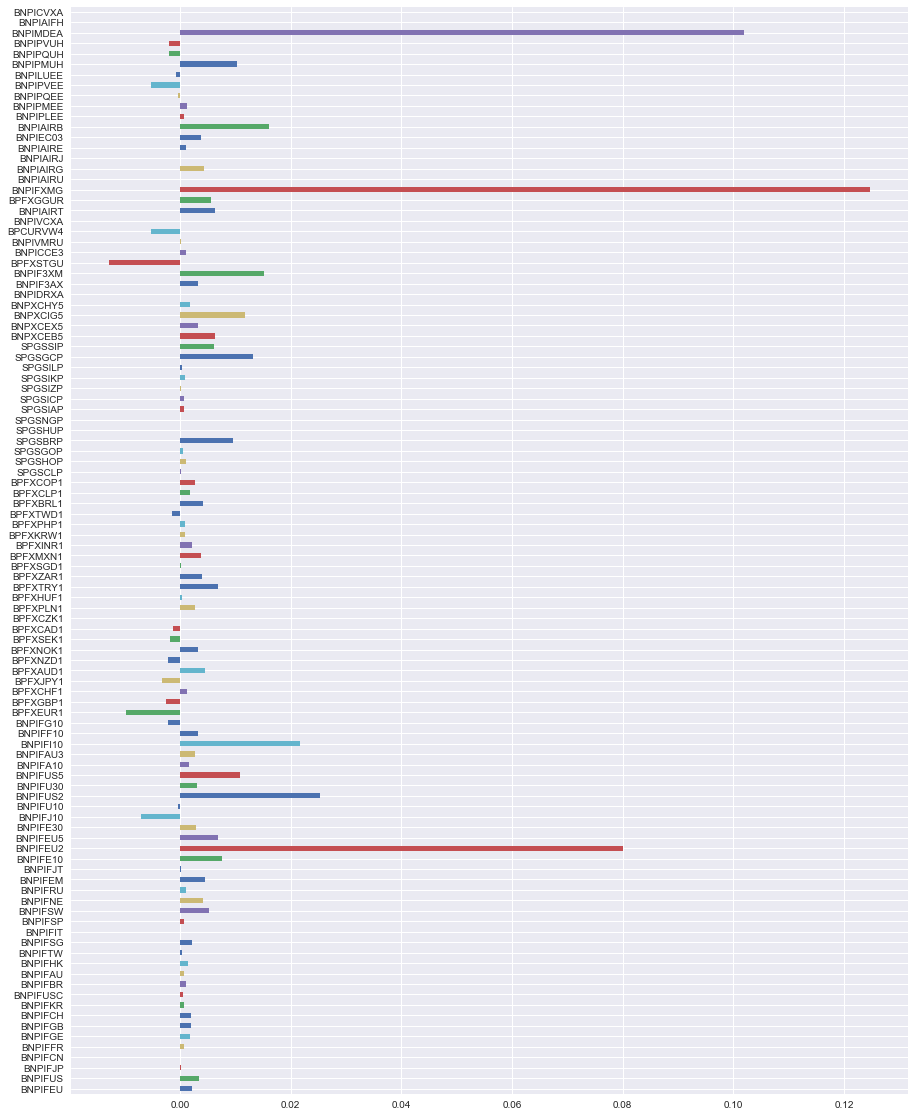

In [37]:
(df_weight_aic).mean(axis=0).plot(kind='barh', figsize=(15,20))

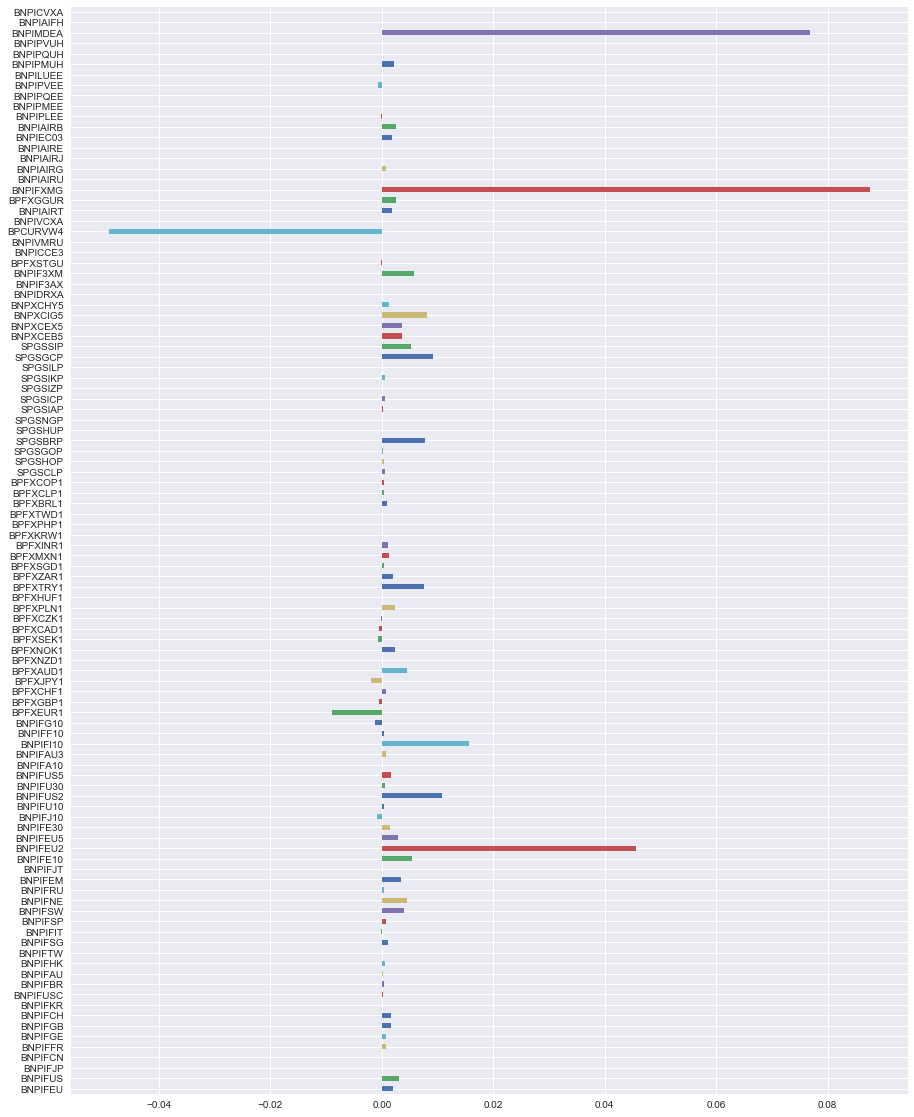

In [38]:
(df_weight_bic).mean(axis=0).plot(kind='barh', figsize=(15,20))

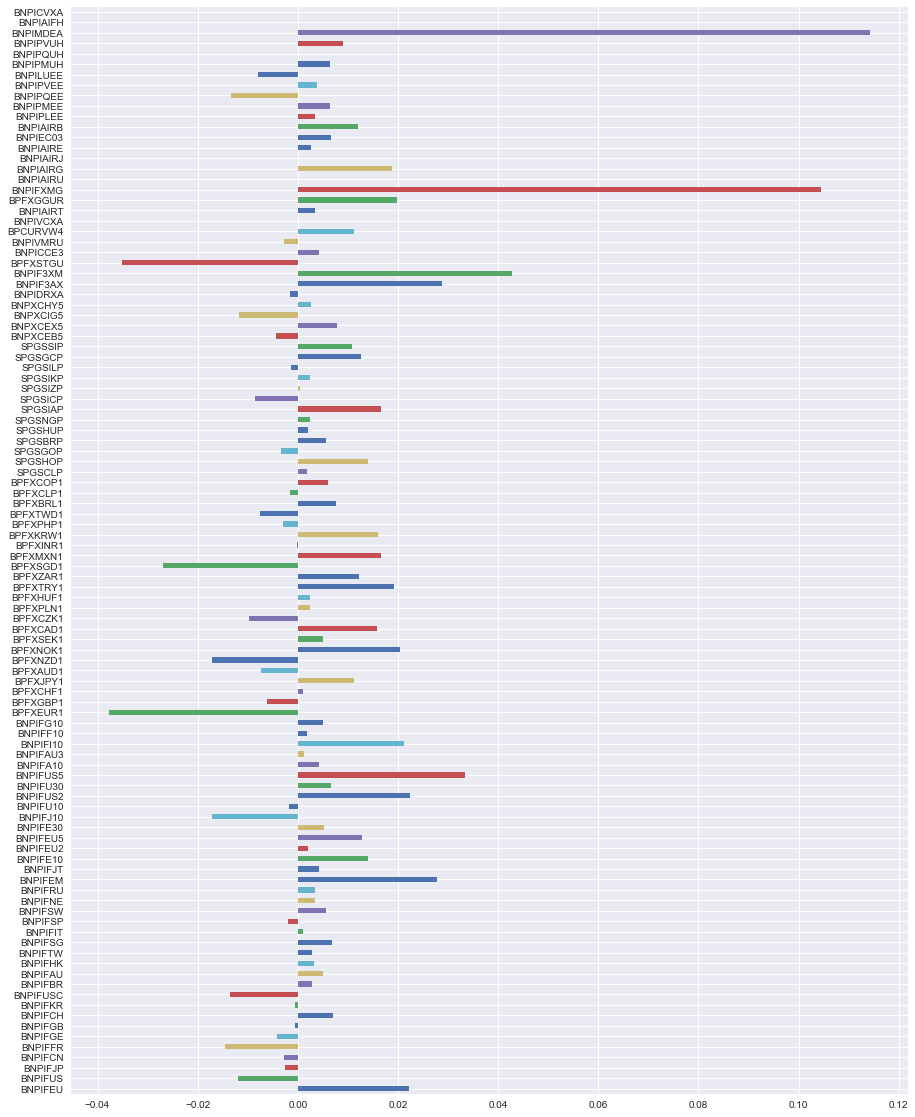

In [39]:
df_weight_kalman.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

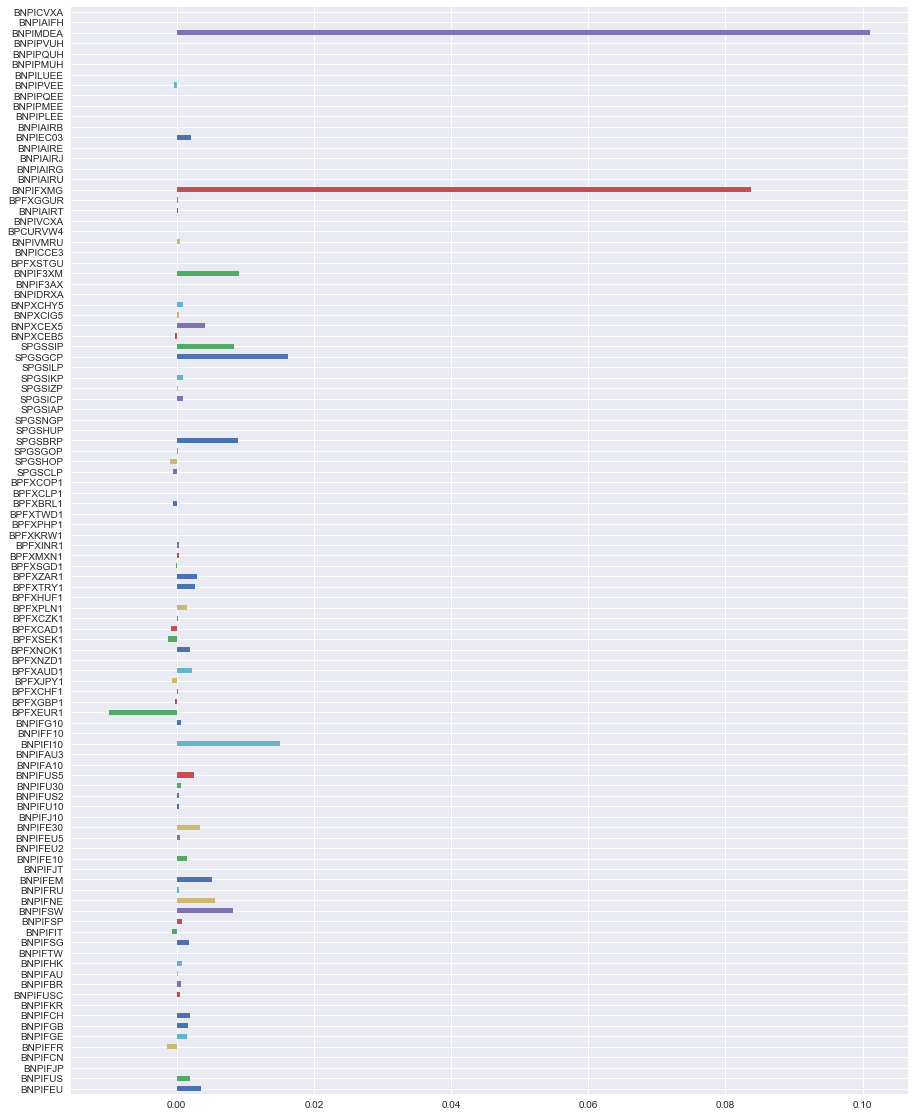

In [40]:
df_weight_kalman_bic.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

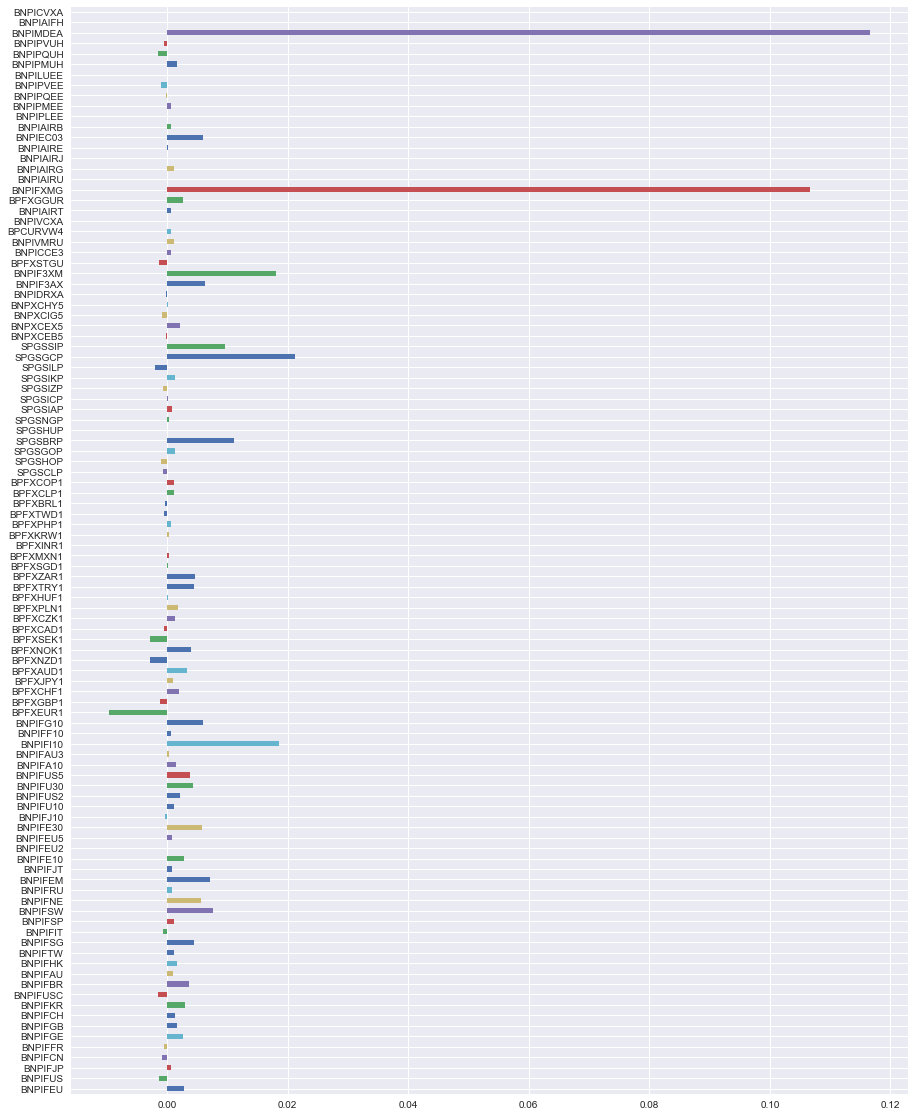

In [41]:
df_weight_kalman_aic.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

In [42]:
limit = 60
df_autocorr = pd.DataFrame(data=[df_res.drop(["Lasso AIC","Lasso BIC"],axis=1)\
                                 .pct_change().apply(lambda col : col.autocorr(lag=i)) for i in range(1,limit)])
df_autocorr[r"$2/\sqrt{n}$"] = [2/np.sqrt(len(df_res)-i) for i in range(1,limit)]
df_autocorr[r"$-2/\sqrt{n}$"] = [-2/np.sqrt(len(df_res)-i) for i in range(1,limit)]

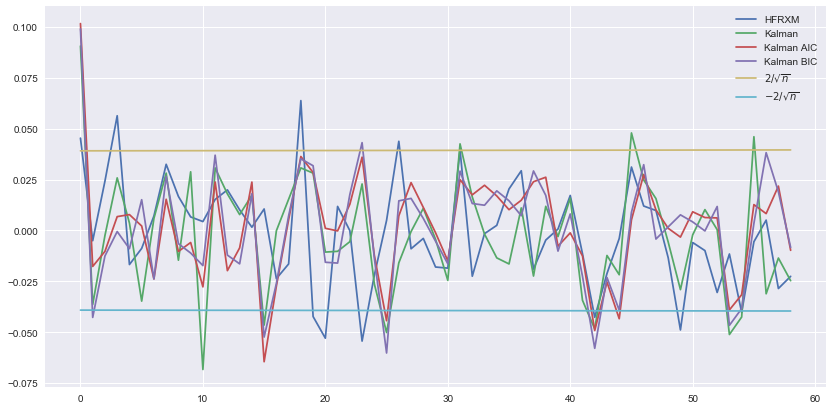

In [43]:
df_autocorr.plot(figsize=(14,7))

In [44]:
df_res[fund_name].pct_change().autocorr(lag=1)

0.045390357033219378

In [45]:
df_res['Kalman'].pct_change().autocorr(lag=1)

0.090669486036571115

In [46]:
df_res['Kalman BIC'].pct_change().autocorr(lag=1)

0.099067449097472726

In [47]:
df_res['Kalman AIC'].pct_change().autocorr(lag=1)

0.10171738071189883

In [48]:
df_res['Lasso AIC'].pct_change().autocorr(lag=1)

0.06162279784672365